[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial6.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial6.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 5: Spatially resolved data

**Week 2, Day 5, Future Climate: The Physical Basis**

**Content creators:** 

**Content reviewers:** 

**Content editors:** 

**Production editors:** 

**Our 2024 Sponsors:** 

# Tutorial Objectives

In this tutorial, we will visualize ocean oxygen changes as a function of not only time, but also latitude, longitude, and depth within the ocean. 

After completing this notebook, you will have the tools to visualize the regional distributions of climate variables in latitude, longitude, and depth. This is the first step toward linking physical changes with their impacts on particular ecosystems or communities.


# Setup

    



In [ ]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

# !pip install condacolab &> /dev/null
# import condacolab
# condacolab.install()

# # Install all packages in one call (+ use mamba instead of conda), this must in one line or code will fail
# !mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null


In [1]:
# imports
import time

tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree   
from xmip.postprocessing import _parse_metric

In [2]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

%matplotlib inline

In [50]:
# @title Helper functions

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uninformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell



# def global_mean(ds: xr.Dataset) -> xr.Dataset:
#     """Global average, weighted by the cell area"""
#     mask = ds.isel(time=0)*0+1
#     return ds.weighted(ds.areacello.fillna(0)).mean(["x", "y"], keep_attrs=True)

def atlantic_mean(ds: xr.Dataset) -> xr.Dataset:
    """Atlantic zonal average, weighted by the cell area"""
    """Ought to remove bathymetry for deeper ocean, have not"""
    return ds.where(ds.basin==2).weighted(ds.areacello.fillna(0)).mean(["x",], keep_attrs=True)
def pacific_mean(ds: xr.Dataset) -> xr.Dataset:
    """Pacific zonal average, weighted by the cell area"""
    """Ought to remove bathymetry for deeper ocean, have not"""
    return ds.where(ds.basin==3).weighted(ds.areacello.fillna(0)).mean(["x",], keep_attrs=True)


# calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # for the coding exercise, ellipses will go after sel on the following line
        ref = dt[model]["historical"].ds.sel(time=slice("1950", "1980")).mean()
        dt_out[model] = subtree - ref
    return dt_out


def regrid(dt, varname, exps):
    target_grid = xe.util.grid_global(1, 1)
    dt_out = DataTree()
    for model in dt.keys():
        model_node = DataTree(name=model, parent=dt_out,)
    
        for experiment in exps:
            da = dt[model][experiment][varname]
            regridder = xe.Regridder(da, target_grid, "bilinear", ignore_degenerate=True, periodic=True, )
            da_rg = regridder(da).drop_vars(('member_id', 'dcpp_init_year'))
            da_rg['y'] = da_rg.lat[:,0]
            da_rg['x'] = np.arange(-179.5,180)#da_rg.lon[0,:]
            
            ds_rg = da_rg.to_dataset(name=varname)
            
            exp_node = DataTree(name=experiment, parent=model_node, data=ds_rg)
        
    return dt_out

# def plot_historical_ssp126_combined(dt):
#     for model in dt.keys():
#         datasets = []
#         for experiment in ["historical", "ssp126"]:
#             datasets.append(dt[model][experiment].ds.tos)

#         da_combined = xr.concat(datasets, dim="time")

In [7]:
# # @title Video 1: Historical Context for Future Projections

# from ipywidgets import widgets
# from IPython.display import YouTubeVideo
# from IPython.display import IFrame
# from IPython.display import display


# class PlayVideo(IFrame):
#   def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
#     self.id = id
#     if source == 'Bilibili':
#       src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
#     elif source == 'Osf':
#       src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
#     super(PlayVideo, self).__init__(src, width, height, **kwargs)


# def display_videos(video_ids, W=400, H=300, fs=1):
#   tab_contents = []
#   for i, video_id in enumerate(video_ids):
#     out = widgets.Output()
#     with out:
#       if video_ids[i][0] == 'Youtube':
#         video = YouTubeVideo(id=video_ids[i][1], width=W,
#                              height=H, fs=fs, rel=0)
#         print(f'Video available at https://youtube.com/watch?v={video.id}')
#       else:
#         video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
#                           height=H, fs=fs, autoplay=False)
#         if video_ids[i][0] == 'Bilibili':
#           print(f'Video available at https://www.bilibili.com/video/{video.id}')
#         elif video_ids[i][0] == 'Osf':
#           print(f'Video available at https://osf.io/{video.id}')
#       display(video)
#     tab_contents.append(out)
#   return tab_contents


# video_ids = [('Youtube', 'lodJMDN6lbg'), ('Bilibili', 'BV1Bu41157mn')]
# tab_contents = display_videos(video_ids, W=730, H=410)
# tabs = widgets.Tab()
# tabs.children = tab_contents
# for i in range(len(tab_contents)):
#   tabs.set_title(i, video_ids[i][0])
# display(tabs)

In [8]:
# # @markdown
# from ipywidgets import widgets
# from IPython.display import IFrame

# link_id = "b4fsp"

# download_link = f"https://osf.io/download/{link_id}/"
# render_link = f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render"
# # @markdown
# out = widgets.Output()
# with out:
#     print(f"If you want to download the slides: {download_link}")
#     display(IFrame(src=f"{render_link}", width=730, height=410))
# display(out)

Output()

# Section 1: Visualize Global O$_2$ for Historical and Future Scenario Experiments

We are now going to load the same oxygen data you saw in Tutorial 4, but average it over longitude, and depth, instead of over the entire volume of the ocean. Later in the tutorial, we will make a comparison of these projected trends to the historical trends.


## Section 1.1: Load CMIP6 Oxygen Data from Several Models using `xarray`

Let's load the five different CMIP6 models again for the three CMIP6 experiments.



In [4]:
col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)  # open an intake catalog containing the Pangeo CMIP cloud data

# pick our five example models
# there are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ["IPSL-CM6A-LR", "GFDL-ESM4", "ACCESS-CM2", "MPI-ESM1-2-LR", "TaiESM1"]
experiment_ids = ["historical", "ssp126", "ssp585"]

In [47]:
## OXYGEN DATA
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id=source_ids,
    variable_id="o2",
    member_id="r1i1p1f1",
    table_id="Omon",
    grid_label="gn",
    experiment_id=experiment_ids,
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt0 = cat.to_datatree(**kwargs)
dt = regrid(dt0, 'o2', ["historical", "ssp126", 'ssp585'])

cat_area = col.search(
    source_id=source_ids,
    variable_id="areacello",  # for the coding exercise, ellipsis' will go after the equals on this line
    member_id="r1i1p1f1",
    table_id="Ofx",  # for the coding exercise, ellipsis' will go after the equals on this line
    grid_label="gn",
    experiment_id=[
        "historical"
    ],  # for the coding exercise, ellipsis' will go after the equals on this line
    require_all_on=["source_id"],
)

cat_area.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_area0 = cat_area.to_datatree(**kwargs)
dt_area = regrid(dt_area0, 'areacello', ['historical'])

cat_basin = col.search(
    source_id=source_ids,
    variable_id="basin",
    member_id="r1i1p1f1",
    table_id="Ofx",  # for the coding exercise, ellipsis' will go after the equals on this line
    grid_label="gn",
    experiment_id=[
        "historical"
    ],  # for the coding exercise, ellipsis' will go after the equals on this line
    require_all_on=["source_id"],
)
cat_basin.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_basin0 = cat_basin.to_datatree(**kwargs)
dt_basin = regrid(dt_basin0, 'basin', ['historical'])

# add 'area' and 'basin' as coords within main o2 datatree
dt_with_area = DataTree()
dt_with_basin = DataTree()

for model, subtree in dt.items():
    metric = dt_area[model]["historical"].ds["areacello"]
    metric2 = (dt_basin[model]["historical"].ds["basin"])
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric, metric)
    dt_with_area_basin[model] = subtree.map_over_subtree(_parse_metric, metric).map_over_subtree(_parse_metric, metric2)






--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


/home/hogikyan/anaconda3/envs/myenv_akh/lib/python3.9/site-packages/xmip/preprocessing.py:229: UserWarning: ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp126.r1i1p1f1.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/hogikyan/anaconda3/envs/myenv_akh/lib/python3.9/site-packages/xmip/preprocessing.py:229: UserWarning: ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.r1i1p1f1.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/hogikyan/anaconda3/envs/myenv_akh/lib/python3.9/site-packages/xmip/preprocessing.py:229: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r1i1p1f1.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


/home/hogikyan/anaconda3/envs/myenv_akh/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/hogikyan/anaconda3/envs/myenv_akh/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/hogikyan/anaconda3/envs/myenv_akh/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/hogikyan/anaconda3/envs/myenv_akh/lib/python3.9/site-packa


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


/home/hogikyan/anaconda3/envs/myenv_akh/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/hogikyan/anaconda3/envs/myenv_akh/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/hogikyan/anaconda3/envs/myenv_akh/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/hogikyan/anaconda3/envs/myenv_akh/lib/python3.9/site-packa

## Section 2: Coding exercise: average over longitude, depth

#### Section 2.1: Average 'zonally' (i.e. in longitude) and use the 'basin' variable to select only the Atlantic Ocean


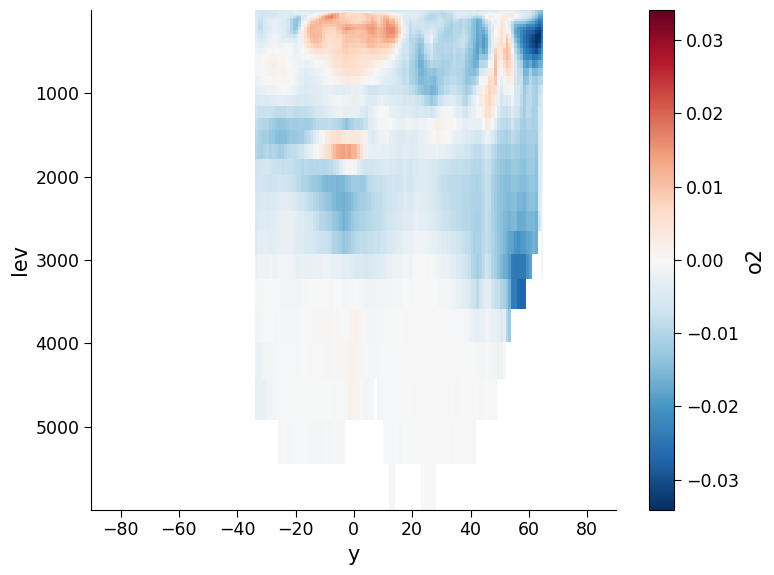

In [51]:
dt_atlm = dt_with_area_basin.map_over_subtree(atlantic_mean)
diff_atl = (dt_atlm['MPI-ESM1-2-LR']["ssp585"].o2.mean('time') - dt_atlm['MPI-ESM1-2-LR']["historical"].o2.mean('time'))
## .sel(time=slice("1950", "1980")).mean('time')


diff_atl.plot(yincrease = False, )


#### Section 2.2: Zonal average over the Pacific Ocean
Examine the available 'helper functions'. Then, using the above code which averaged over the Atlantic, plot an average across the Pacific.


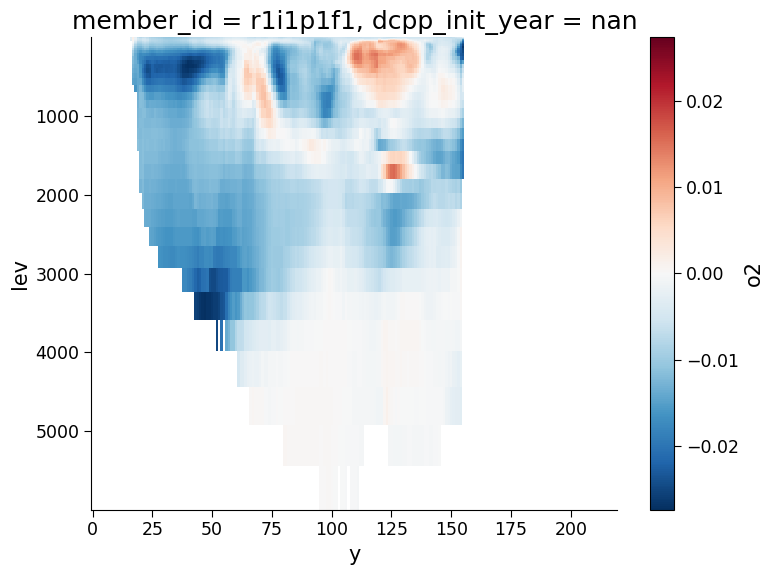

In [6]:
dt_pacm = ...

diff_pac = ...
diff_pac.plot(yincrease = False, y=diff_pac.latitude)


#### Section 2.3: Average vertically over a depth range
We can also compare the result to a published figure

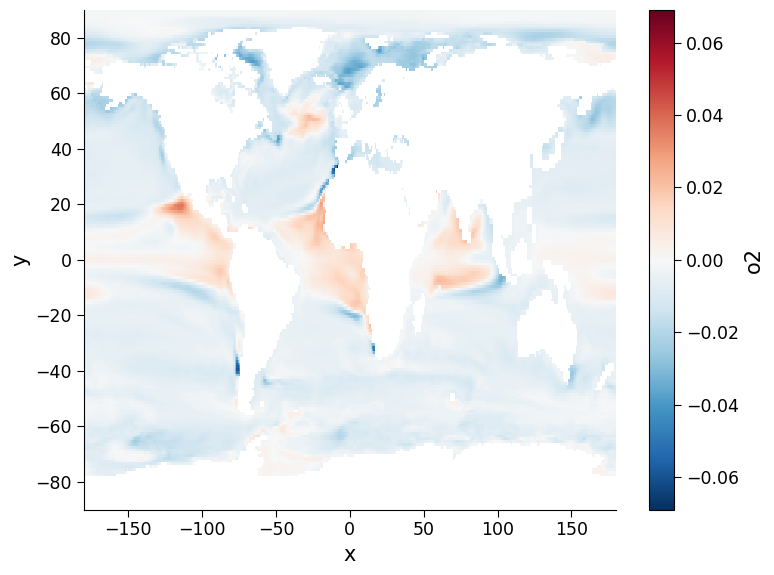

In [56]:
diff = (dt['MPI-ESM1-2-LR']["ssp585"].o2.mean('time') - dt['MPI-ESM1-2-LR']["historical"].o2.mean('time'))

z = da.lev
        
long_z = np.zeros(len(z)+2)
long_z[1:-1] = z
long_z[-1] = long_z[-2]+(long_z[-2] - long_z[-3])
center_z = (long_z[1:] + long_z[0:-1]) / 2
dz = xr.DataArray(np.diff(center_z), coords=[da.lev], dims=['lev'])
        
top200_diff = diff.sel(lev = slice(0,200)).weighted(dz.sel(lev = slice(0,200))).mean(["lev"], keep_attrs=True)



top200_diff.plot()
plt.title('Mean oxygen change between ssp585 and historical period\n0-200m depth')



### Questions 1.1 Climate Connection

Now that you have the simulated oxygen distribution:
1. Describe the major similarities and differences between the simulated changes and these observation-based estimates? Is the modeled historical trend similar to the observed historical trend? Is the modeled future projection similar to both estimates of the historical trend?
2. Why might the changes not be uniform globally? What might affect regional patterns, both horizontal and vertical (recall mechanisms explained in the video)?
 

![](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/img/W2D1_Tutorial_5_Insert_Ito2017_Figure.png?raw=true)

This image is from study 'Upper ocean O$_2$ trends: 1958–2015' (Ito et al. 2017). Their caption:

(a) Global map of the linear trend of O2 time series at the depth of 100 m. We plot the linear trend for the grid cells where the effective sample size (Neff) is greater than 20. (b) Same as Figure 3a but at the depth of 400 m. (c) Same as Figure 3a but at the depth of 700 m. We indicate the regions where there are insufficient data (Neff < 20) by black dots.



In [ ]:
# to_remove explanation

"""
1. I will let you decide what you take away from creating these figures!
""";

# Summary

In the final tutorial of the day, we learned how to visualize not only global-mean changes, but also the spatial distribution of these changes in ocean oxygen. You could apply these skills to look at other variables as well. For example, in Tutorial 4, we loaded surface temperature data but then only plotted the global mean. Are you curious about the projected or observed regional changes in temperature? Where do you live, and has it warmed more or less there compared to other regions? 

In the upcoming tutorials, we will shift our focus towards the socio-economic aspects of future climate change. This exploration will take various forms, including the design of the Shared Socioeconomic Pathways (SSPs) we began using today. We'll contemplate the realism of different socio-economic future scenarios and examine their potential impacts on future climate forcings. Moreover, we'll delve into how a changing climate might affect society. As we proceed with the next tutorials, keep in mind the intricate connection between physical and socio-economic changes.

# Resources

This tutorial uses data from the simulations conducted as part of the [CMIP6](https://wcrp-cmip.org/) multi-model ensemble.

For examples on how to access and analyze data, please visit the [Pangeo Cloud CMIP6 Gallery](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/index.html)

For more information on what CMIP is and how to access the data, please see this [page](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md).